# ImageNet - Bayesian Optimization 
## 02463 Active ML and Agency - Group BO 2

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms

In [16]:
# dataset path
imagenetmini_path = "./imagenetmini-1000/imagenet-mini"

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=f"{imagenetmini_path}/train", transform=transform)
val_dataset = ImageFolder(root=f"{imagenetmini_path}/val", transform=transform)

# dataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 34745
Validation dataset size: 3923


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].
Clipping input da

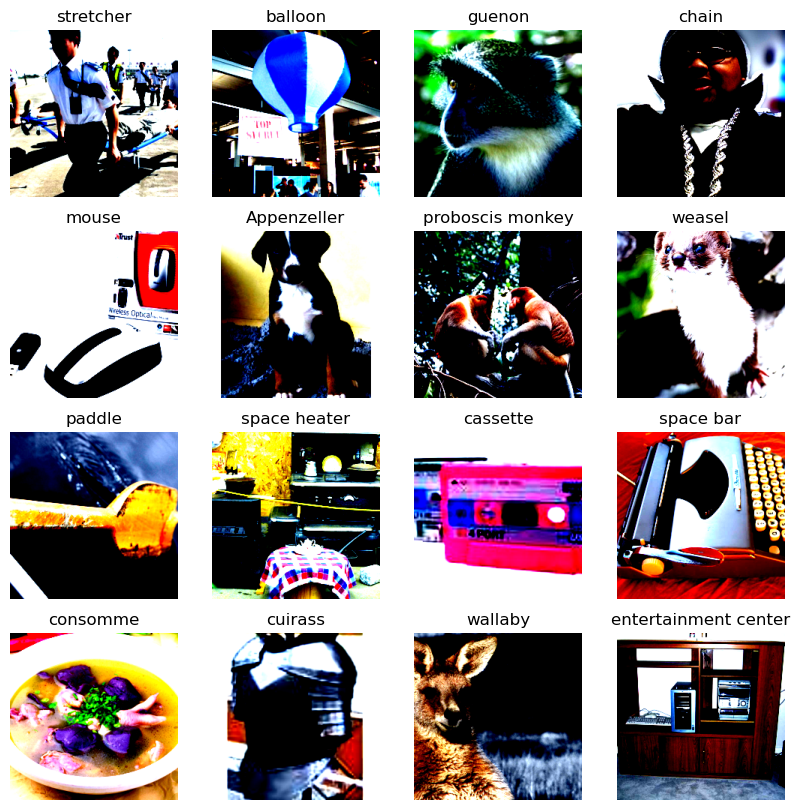

In [ ]:
images, labels = next(iter(train_loader))

class_names = train_dataset.classes  # List of folder names (ImageNet classes)

def denormalize(image):
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1) 
    return image

# Convert folder names (WordNet IDs) to human-readable labels
# Load ImageNet class mappings
imagenet_classes = open("./imagenet_classes.txt", "r").read().splitlines()
imagenet_wordnet_mapping = {str(i): label for i, label in enumerate(imagenet_classes)}
class_mappings = {str(k): imagenet_wordnet_mapping[str(v)] for k, v in train_dataset.class_to_idx.items()}

# Plot images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = denormalize(images[i])  # Convert from (C, H, W) to (H, W, C)
    label = class_mappings[train_dataset.classes[labels[i]]]  # Get human-readable label
    ax.imshow(img)
    ax.set_title(label[:20])  # Truncate long names
    ax.axis("off")

plt.show()